In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.cluster as cluster

In [2]:
import at2df

# Analyze Cryptopolitics survey results

## Import data

In [3]:
at = at2df.get_airtable()

In [5]:
df = at2df.get_table_as_df(at, 'Cryptopolitical Typology Quiz')

In [10]:
cols_questions = ['1. Which statement comes closest to your views?', 
                  '2. Which blockchain is the best?','3', '4', '5', '6', '7', '8',
                  '9. In order to grow, the crypto ecosystem should:','10', '11', '12', '13',
                  '14. To get more favorable regulation of cryptocurrencies from national governments, the most important thing the crypto community can do is:',
                  '15', '16. Who should have decision-making power over a blockchain?', '17. I\'m here for...',
                  '18. Do you consider yourself:', '19. OPTIONAL: Do you affiliate with any of the following ecosystems or communities?']
cols_results = ['classification', 'politics', 'economics', 'governance', 'maxi']

df_questions = df[cols_questions] # Only the questions asked
df_results = df[cols_results] # Only the faction results

## Distribution of factions

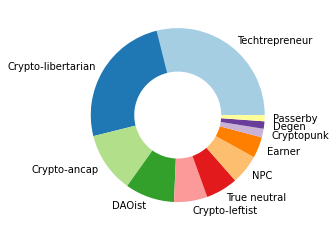

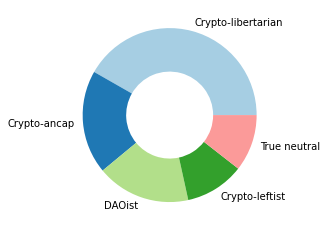

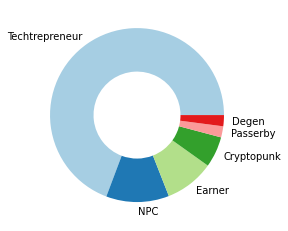

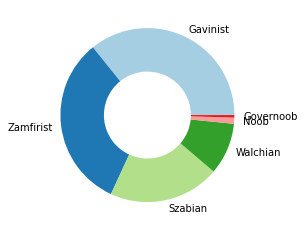

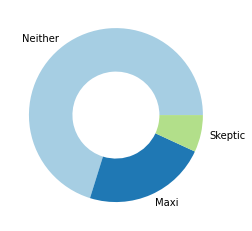

In [35]:
# Pie chart for specific dimensions
for col in cols_results:
    vals = df_results[col].value_counts()
    plt.figure()
    labels = vals.keys()
    if col == 'maxi':
        labelShortener = {"You are neither a crypto maxi nor a crypto skeptic. So balanced!": 'Neither',
                          "You're also a Maxi.": 'Maxi', "You're also a Skeptic.": "Skeptic"}
        labels = [labelShortener[x] for x in labels]
    plt.pie(vals, labels=labels, colors=sns.color_palette("Paired"), wedgeprops=dict(width=0.5))

## Correlation table/heat map
For all pairs of questions, cross-tabulate and calculate Cramer's V for strength of relation

In [59]:
def cramers_v(q1, q2):
    """Calculate Cramer's V for two categorical questions by cross-tabulating"""
    
    assert len(q1.index) == len(q2.index), "Make sure the datasets are of equal length"
    
    # Some questions have list as response; skip these
    try:
        ct = pd.crosstab(q1, q2)
    except TypeError:
        return np.nan
    
    chi2 = stats.chi2_contingency(ct)[0]
    n = len(q1.index) # Is the same as for q2
    nRows, nCols = ct.shape
    minDim = min(nRows-1, nCols-1)
    
    # Only compute if both questions have at least two observed responses (counterexample: Q2 is only answered for one answer to Q1)
    if minDim == 0:
        return np.nan
    
    V = np.sqrt((chi2/n)/minDim)
    
    return V

In [60]:
# Get Cramer's V for each question
nQuestions = len(df_questions.columns)
cramersMatrix = np.zeros((nQuestions, nQuestions))

for i, c1 in enumerate(cols_questions):
    for j, c2 in enumerate(cols_questions):
        # Select only rows for which both questions were answered
        df_tmp = df_questions[pd.notnull(df_questions[c1]) & pd.notnull(df_questions[c2])]
        cramersMatrix[i, j] = cramers_v(df_tmp[c1], df_tmp[c2])

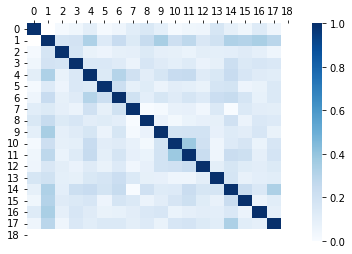

In [61]:
# Plot heatmap of Cramer's V
plt.figure()
fig = sns.heatmap(cramersMatrix, cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
fig.xaxis.set_ticks_position("top")

## Ethereum v. Bitcoin

In [73]:
col = '19. OPTIONAL: Do you affiliate with any of the following ecosystems or communities?'
df_tmp = df_questions[pd.notnull(df_questions[col])]
df_eth = df_tmp.loc[df_tmp[col].apply(lambda x: 'Ethereum' in x)]
df_btc = df_tmp.loc[df_tmp[col].apply(lambda x: 'Bitcoin' in x)]
print(len(df_eth.index))
print(len(df_btc.index))

323
91


## Clustering
Crypto sentiment on axes: can we describe clusters in a meaningful way?